In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import re

# Scikitlearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import ComplementNB, MultinomialNB


from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from textblob import TextBlob

In [3]:
# Loading Data
df = pd.read_csv('Datasets/Tweets.csv')

In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df.shape

(14640, 15)

In [6]:
# Target value 
df['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [7]:
# Drop the columns 
df = df.drop(['tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone'], axis=1)

In [8]:
df.head(20)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."
7,neutral,@VirginAmerica Really missed a prime opportuni...
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an ..."


### Preprocessing

In [ ]:
# I am gonna define a function to clean the text data 
def clean_text(text):
    
    text = re.sub(r'(@\w+|RT\s+)', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r"[^\w\s'-]", '', text)
    return re.sub(r'\s+', ' ', text).strip().lower()
    

# I got structure code from lecture node but I modified it, I added  @mentions, RT tags.
df['text'] = df['text'].apply(clean_text)

**I think for sentiment analyzing, I need to keep stop words, Because words like: No and not are meaningful**

In [10]:
df.head(20)

,airline_sentiment,text
0,neutral,what said
1,positive,plus you've added commercials to the experienc...
2,neutral,i didn't today must mean i need to take anothe...
3,negative,it's really aggressive to blast obnoxious ente...
4,negative,and it's a really big bad thing about it
5,negative,seriously would pay 30 a flight for seats that...
6,positive,yes nearly every time i fly vx this ear worm w...
7,neutral,really missed a prime opportunity for men with...
8,positive,well i didn'tbut now i do -d
9,positive,it was amazing and arrived an hour early you'r...


In [11]:
# check the null values
df.isnull().sum()

airline_sentiment    0
text                 0
dtype: int64

In [12]:
df['airline_sentiment'].value_counts()   

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [13]:
# save the cleaned data
df.to_csv('Datasets/cleaned_tweets.csv', index=False)

In [14]:
X = df['text']  
y = df['airline_sentiment']

In [15]:
# Vectorization
tfidf = TfidfVectorizer()  
X = tfidf.fit_transform(X)

In [16]:
# using the RandomUnderSampler to balance 
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

In [17]:
y.value_counts()

airline_sentiment
neutral     9178
positive    9178
negative    9178
Name: count, dtype: int64

In [18]:
y.value_counts()

airline_sentiment
neutral     9178
positive    9178
negative    9178
Name: count, dtype: int64

In [19]:
# train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)    

In [20]:
y.value_counts()

airline_sentiment
neutral     9178
positive    9178
negative    9178
Name: count, dtype: int64

## Model

In [21]:
model = ComplementNB()

In [22]:
param_grid = {
    'alpha': [0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 5.0, 7, 10.0],
    'fit_prior': [True, False]  
}

# Grid search 
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',   
    cv=5,                 
    n_jobs=-1,            
    verbose=1             
)
grid_search.fit(X_train, y_train)
# Best parameters and best model
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'alpha': 0.1, 'fit_prior': True}


In [23]:
model = ComplementNB(alpha=0.1, fit_prior=True)                

model.fit(X_train, y_train)

ComplementNB(alpha=0.1)

In [24]:
# Predictions 
predictions = model.predict(X_test)

## Evaluating the Model

In [25]:
# Classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

    negative       0.86      0.83      0.84      1823
     neutral       0.86      0.81      0.84      1828
    positive       0.87      0.94      0.90      1856

    accuracy                           0.86      5507
   macro avg       0.86      0.86      0.86      5507
weighted avg       0.86      0.86      0.86      5507



**Overall accuracy and Macro Avg is 86%, that means model works correctly balanced across three classes**<br>
**For Positive class recall is so high, but precision is 87. The model does not distinguish neutral from negative (both have recall ~81-83%).**  

<Axes: >

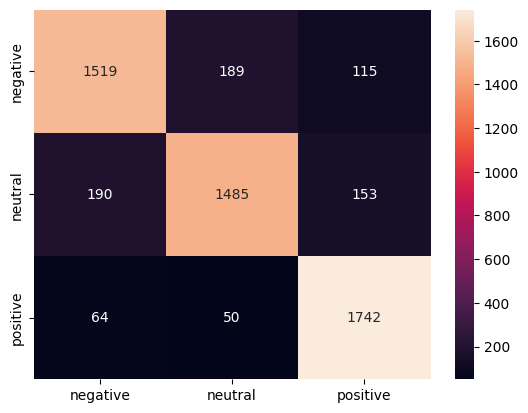

In [26]:
sns.heatmap(confusion_matrix(y_test, predictions, labels=model.classes_), annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_)  

## Testing the model with unseen data

In [27]:
import requests
from bs4 import BeautifulSoup

url = 'https://www.airlinequality.com/'
headers = {
    'User-Agent': 'Mozilla/5.0'
}
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, 'html.parser')

# Finding all reviews for the airline 
review_divs = soup.find_all('div', class_='text_content')

# Collecting all reviews into a list
all_reviews = []
for div in review_divs:
    review_text = div.get_text(strip=True)
    all_reviews.append(review_text)

# Convert to DataFrame
unseen_data = pd.DataFrame(all_reviews, columns=['text'])
unseen_data.head()

# For collecting reviews, I  used Qwen 2.5

,text
0,✅ Trip Verified | I was booked from Singapore ...
1,"✅ Trip Verified | Everything was OK, except th..."
2,✅ Trip Verified | My flight was supposed to le...
3,Not Verified | They changed the aircraft from ...
4,✅ Trip Verified | I had booked 6 Business clas...


In [28]:
# Delete the Trip verified text from each review
unseen_data["text"] = unseen_data["text"].str.replace("Trip Verified", "")
unseen_data.head()
# I got 12 reviews from the website

,text
0,✅ | I was booked from Singapore to London and...
1,"✅ | Everything was OK, except the seat reserv..."
2,✅ | My flight was supposed to leave Amsterdam...
3,Not Verified | They changed the aircraft from ...
4,✅ | I had booked 6 Business class tickets and...


## Preprocessing over unseen data

In [29]:
# I am gonna apply the clean_text function to the text column
unseen_data["text"] = unseen_data["text"].apply(clean_text) 
unseen_data.head()

,text
0,i was booked from singapore to london and flew...
1,everything was ok except the seat reservation ...
2,my flight was supposed to leave amsterdam at 2...
3,not verified they changed the aircraft from an...
4,i had booked 6 business class tickets and was ...


In [30]:
# save the unseen data
unseen_data.to_csv('Datasets/unseen_data.csv', index=False)

In [31]:
# Vectorization
X_unseen = tfidf.transform(unseen_data["text"])

In [32]:
# Predictions
predictions_unseen = model.predict(X_unseen)

In [33]:
# Check the predictions and the reviews
unseen_data["airline_sentiment"] = predictions_unseen
unseen_data.head(12)

,text,airline_sentiment
0,i was booked from singapore to london and flew...,negative
1,everything was ok except the seat reservation ...,negative
2,my flight was supposed to leave amsterdam at 2...,negative
3,not verified they changed the aircraft from an...,negative
4,i had booked 6 business class tickets and was ...,negative
5,seat 16a on psa airlines crj-900 is an excelle...,neutral
6,flying with etihad from singapore to abu dhabi...,negative
7,outstanding business class lounge at doha airp...,positive
8,what impressed me first was the elegant entran...,negative
9,friendly and professional security staff does ...,positive


**It seems, model classified mostly correct.**